In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 0.001
NUM_CLASSES = 7
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

EMOTION_LABELS = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

print(f"Using device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")

Using device: cpu
Random seed: 42


In [ ]:
# ============================================
# KAGGLE DATASET DOWNLOAD
# ============================================

!pip install -q kaggle

# Upload kaggle.json (only need to run once per session)
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download RAF-DB dataset
print("\nDownloading RAF-DB dataset from Kaggle...")
!kaggle datasets download -d shuvoalok/raf-db-dataset

# Unzip dataset
print("\nExtracting dataset...")
!unzip -q raf-db-dataset.zip

print("✅ Dataset downloaded and extracted successfully!\n")


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
License(s): other
  0% 0.00/37.7M [00:00<?, ?B/s]
100% 37.7M/37.7M [00:00<00:00, 1.08GB/s]

Extracting dataset...
✅ Dataset downloaded and extracted successfully!



In [ ]:
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_val_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_val_acc + self.min_delta:
            self.best_val_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Geometric augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    # Color augmentations
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),

    # Blur and noise
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    # Cutout/Random Erasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])


# Load training data
base_dataset = datasets.ImageFolder(root="./DATASET/train")

# Split training into train (80%) and validation (20%)
train_size = int(0.8 * len(base_dataset))
val_size = len(base_dataset) - train_size

# Use fixed seed to ensure everyone gets same split
torch.manual_seed(RANDOM_SEED)
train_dataset, val_dataset = random_split(base_dataset, [train_size, val_size])

#Apply different transformation to training and validation dataset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = transform

# Load test data
test_dataset = datasets.ImageFolder(root="./DATASET/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print dataset info
print(f"Dataset Split Summary:")
print(f"{'='*60}")
print(f"Training samples: {len(train_dataset)} ({len(train_dataset)/len(base_dataset)*100:.1f}%)")
print(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/len(base_dataset)*100:.1f}%)")
print(f"Test samples: {len(test_dataset)}")
print(f"Total samples: {len(base_dataset) + len(test_dataset)}")
print(f"{'='*60}\n")

# Calculate class weights for imbalanced dataset
train_labels = [base_dataset.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_labels)

print(f"Class distribution in training set:")
print(f"{'='*60}")
for i in range(NUM_CLASSES):
    count = train_counts[i]
    percentage = count / len(train_dataset) * 100
    print(f"  {EMOTION_LABELS[i]:<15}: {count:>5} ({percentage:>5.1f}%)")
print(f"{'='*60}\n")

class_counts = np.array([train_counts[i] for i in range(NUM_CLASSES)])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

print(f"Class weights for loss function:")
print(f"{'='*60}")
for i in range(NUM_CLASSES):
    print(f"  {EMOTION_LABELS[i]:<15}: {class_weights[i]:.4f}")
print(f"{'='*60}\n")

Dataset Split Summary:
Training samples: 9816 (80.0%)
Validation samples: 2455 (20.0%)
Test samples: 3068
Total samples: 15339

Class distribution in training set:
  Surprise       :  1026 ( 10.5%)
  Fear           :   228 (  2.3%)
  Disgust        :   564 (  5.7%)
  Happiness      :  3875 ( 39.5%)
  Sadness        :  1576 ( 16.1%)
  Anger          :   574 (  5.8%)
  Neutral        :  1973 ( 20.1%)

Class weights for loss function:
  Surprise       : 0.6640
  Fear           : 2.9879
  Disgust        : 1.2079
  Happiness      : 0.1758
  Sadness        : 0.4323
  Anger          : 1.1868
  Neutral        : 0.3453



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

def evaluate_model(model, loader, model_name="Model"):
    """
    Comprehensive evaluation of a model.
    Returns: accuracy, confusion matrix, and classification metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Overall accuracy
    accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Per-class metrics
    print(f"\n{'='*60}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*60}")
    print(classification_report(all_labels, all_preds,
                                target_names=EMOTION_LABELS,
                                digits=4))

    # Precision, Recall, F1 per class
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    print(f"\n{'='*60}")
    print(f"Per-Class Metrics Summary")
    print(f"{'='*60}")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*60}")
    for i in range(NUM_CLASSES):
        print(f"{EMOTION_LABELS[i]:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    print(f"{'-'*60}")
    print(f"{'Average':<15} {avg_precision:<12.4f} {avg_recall:<12.4f} {avg_f1:<12.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'support': support
    }


def measure_inference_time(model, loader, num_batches=10):
    """
    Measure average inference time per batch
    """
    model.eval()
    times = []

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break

            images = images.to(DEVICE)

            # Measure time
            start_time = time.time()
            _ = model(images)
            end_time = time.time()

            times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    return avg_time


def count_parameters(model):
    """
    Count total and trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
def plot_training_curves(history, model_name="Model"):
    """
    Plot training and validation loss/accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_title(f'{model_name} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.05)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.15)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.25)

        # Block 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout2d(0.35)

        # Classifier
        self.fc1 = nn.Linear(256 * 14 * 14, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.drop4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Initialize model
model = EmotionCNN(num_classes=NUM_CLASSES).to(DEVICE)
model_name = "CNN"

# Print model info
total_params, trainable_params = count_parameters(model)
print(f"\\n{model_name} Model Info:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")


\nCNN Model Info:
  Total parameters: 6,811,975
  Trainable parameters: 6,811,975
  Model size: 25.99 MB (float32)



Training CNN

Epoch 01/40 | Train Loss: 2.0388 | Train Acc: 16.86% | Val Loss: 2.0084 | Val Acc: 34.58%
Epoch 02/40 | Train Loss: 2.0027 | Train Acc: 24.55% | Val Loss: 1.9505 | Val Acc: 26.84%
EarlyStopping counter: 1/7
Epoch 03/40 | Train Loss: 1.9292 | Train Acc: 31.13% | Val Loss: 1.8298 | Val Acc: 42.69%
Epoch 04/40 | Train Loss: 1.8236 | Train Acc: 37.84% | Val Loss: 1.6980 | Val Acc: 45.87%
Epoch 05/40 | Train Loss: 1.7566 | Train Acc: 42.62% | Val Loss: 1.6352 | Val Acc: 54.75%
Epoch 06/40 | Train Loss: 1.6775 | Train Acc: 47.27% | Val Loss: 1.5809 | Val Acc: 55.40%
Epoch 07/40 | Train Loss: 1.6062 | Train Acc: 50.55% | Val Loss: 1.5238 | Val Acc: 57.47%
Epoch 08/40 | Train Loss: 1.5637 | Train Acc: 52.68% | Val Loss: 1.5065 | Val Acc: 61.71%
Epoch 09/40 | Train Loss: 1.5356 | Train Acc: 53.92% | Val Loss: 1.4764 | Val Acc: 57.88%
EarlyStopping counter: 1/7
Epoch 10/40 | Train Loss: 1.4953 | Train Acc: 55.83% | Val Loss: 1.4422 | Val Acc: 59.67%
EarlyStopping counter: 2/7
Epoc

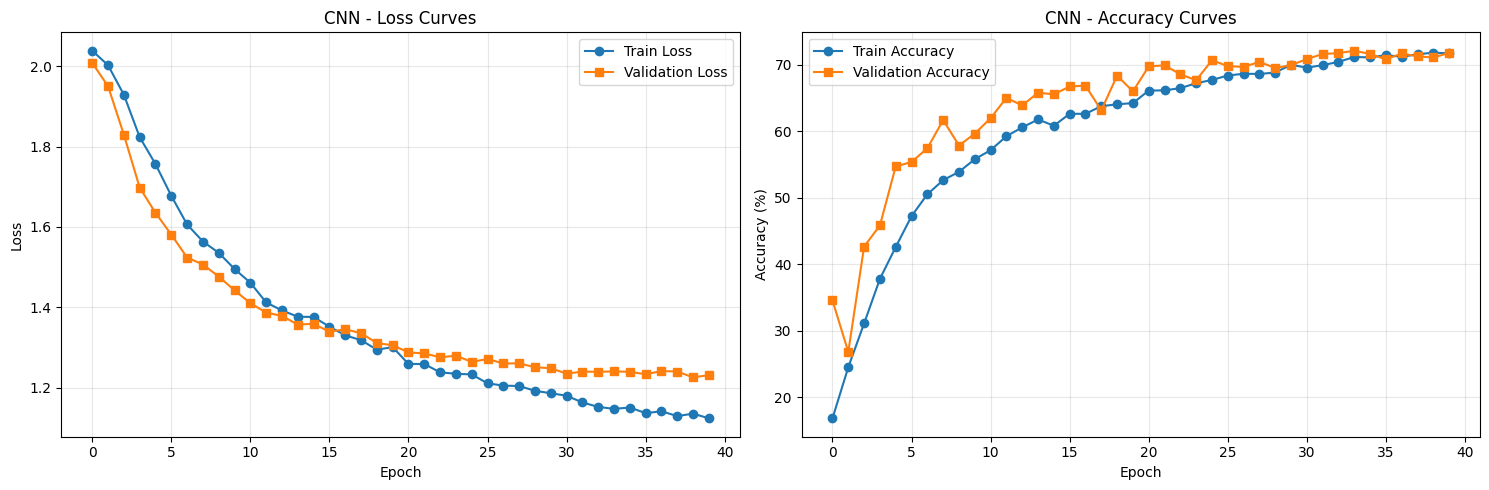

In [ ]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=5e-5
)

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)



# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training
best_val_acc = 0.0
best_epoch = 0

print(f"\n{'='*60}")
print(f"Training {model_name}")
print(f"{'='*60}\n")

early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f'{model_name}_best.pth')



    # Print progress
    print(f'Epoch {epoch+1:02d}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    if early_stopping(val_acc):
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step()

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"{'='*60}\n")

# Plot training curves
plot_training_curves(history, model_name)


FINAL EVALUATION - CNN



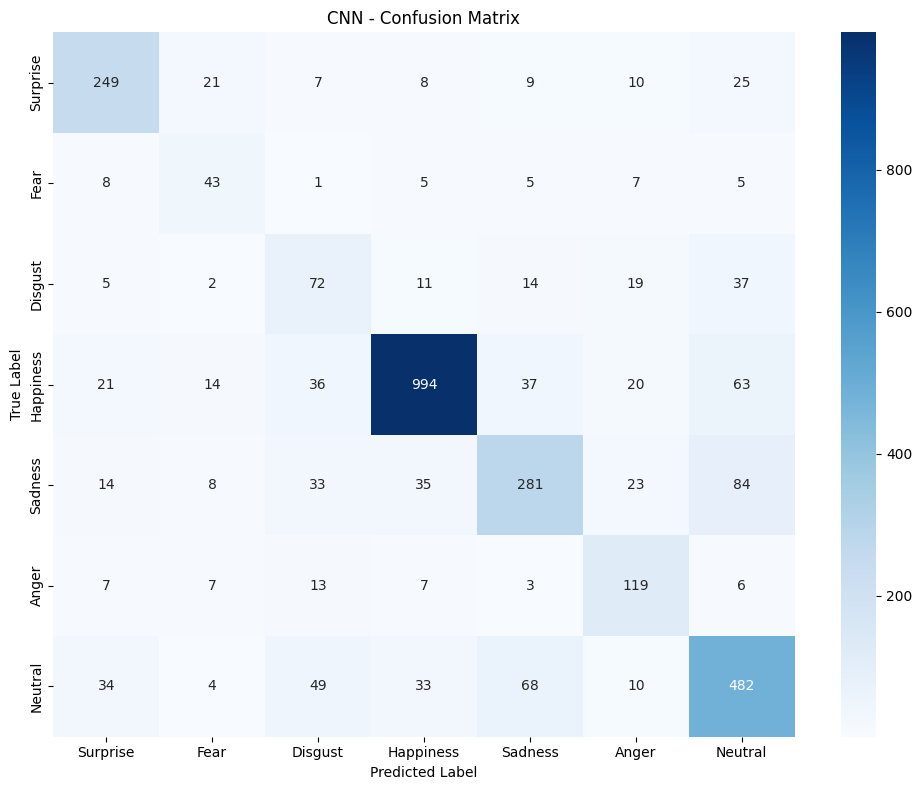


CNN - Classification Report
              precision    recall  f1-score   support

    Surprise     0.7367    0.7568    0.7466       329
        Fear     0.4343    0.5811    0.4971        74
     Disgust     0.3412    0.4500    0.3881       160
   Happiness     0.9094    0.8388    0.8727      1185
     Sadness     0.6739    0.5879    0.6279       478
       Anger     0.5721    0.7346    0.6432       162
     Neutral     0.6866    0.7088    0.6975       680

    accuracy                         0.7301      3068
   macro avg     0.6220    0.6654    0.6390      3068
weighted avg     0.7459    0.7301    0.7358      3068


Per-Class Metrics Summary
Class           Precision    Recall       F1-Score     Support   
------------------------------------------------------------
Surprise        0.7367       0.7568       0.7466       329       
Fear            0.4343       0.5811       0.4971       74        
Disgust         0.3412       0.4500       0.3881       160       
Happiness       0.9094

In [ ]:
# ============================================
# FINAL EVALUATION ON TEST SET
# ============================================

# Load best model
model.load_state_dict(torch.load("CNN_best v3.pth", map_location=DEVICE))

print(f"\n{'='*60}")
print(f"FINAL EVALUATION - {model_name}")
print(f"{'='*60}\n")

# Evaluate on test set
test_metrics = evaluate_model(model, test_loader, model_name)

# Measure inference time
inference_time = measure_inference_time(model, test_loader)

# Summary
print(f"\n{'='*60}")
print(f"{model_name} - Final Results Summary")
print(f"{'='*60}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Average Inference Time: {inference_time:.2f} ms/batch")
print(f"Total Parameters: {total_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"{'='*60}\n")
